# Explainability for GNNs

In this notebook, I want to try out the interpretation package for GNNs from PyTorch.

## Node and Edge Importance

### Environment setup and imports

In [22]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.data import Data
import os

In [23]:
from enc_dec.geo_webgnn_decoder import WeBGNNDecoder
from geo_loader.read_geograph import read_batch
from geo_loader.geograph_sampler import GeoGraphLoader

Supposedly, GNNExplainer from PyTorch can help understand which parts of the graph (nodes and edges) are most influential for a given prediction. For our WeBGNNDecoder, which predicts drug synergy, we want to explain the prediction for a specific pair of drugs.

### Dataset information loading

In [24]:
def load_dataset_info(dataset='data-oneil'):
    """
    Load all dataset information including gene and drug counts, names, and network structure:

    - Number of genes and drugs in the dataset
    - Gene and drug names for interpretation
    - Network structure information (edges between genes and drugs)
    
    Returns:
        dict: Contains all dataset information needed for model setup and explanation
    """
    gene_df = pd.read_csv(f'./{dataset}/filtered_data/kegg_gene_annotation.csv')
    drug_df = pd.read_csv(f'./{dataset}/filtered_data/drug_num_dict.csv')
    gene_edge_df = pd.read_csv(f'./{dataset}/filtered_data/kegg_gene_num_interaction.csv')
    drugbank_df = pd.read_csv(f'./{dataset}/filtered_data/final_drugbank_num_sym.csv')
    
    num_gene = len(gene_df)
    num_drug = len(drug_df)
    node_num = num_gene + num_drug
    num_gene_edge = len(gene_edge_df)
    num_drug_edge = len(drugbank_df)
    num_edge = num_gene_edge + num_drug_edge
    
    # Store names for interpretation
    gene_names = list(gene_df['kegg_gene'])
    drug_names = list(drug_df['Drug'])
    
    dataset_info = {
        'num_gene': num_gene,
        'num_drug': num_drug,
        'node_num': node_num,
        'num_gene_edge': num_gene_edge,
        'num_drug_edge': num_drug_edge,
        'num_edge': num_edge,
        'gene_names': gene_names,
        'drug_names': drug_names
    }
    
    print(f"Dataset info - Genes: {num_gene}, Drugs: {num_drug}, Total nodes: {node_num}")
    print(f"Network info - Gene edges: {num_gene_edge}, Drug edges: {num_drug_edge}, Total edges: {num_edge}")
    
    print(f"All {num_drug} drugs in the dataset:")
    for i, drug in enumerate(drug_names, 1):
        print(f"   {i:2d}. {drug}")

    print(f"Genes in the dataset (showing first 10 of {num_gene} total):")
    for i, gene in enumerate(gene_names[:10], 1):
        print(f"      {i:2d}. {gene}")
    
    return dataset_info

Here is our dataset information.

In [25]:
dataset_info = load_dataset_info('data-oneil')

Dataset info - Genes: 2016, Drugs: 11, Total nodes: 2027
Network info - Gene edges: 18512, Drug edges: 92, Total edges: 18604
All 11 drugs in the dataset:
    1. Dasatinib
    2. Erlotinib
    3. Lapatinib
    4. Sorafenib
    5. Sunitinib
    6. Vorinostat
    7. dexamethasone
    8. geldanamycin
    9. metformin
   10. paclitaxel
   11. vinblastine
Genes in the dataset (showing first 10 of 2016 total):
       1. ABL1
       2. ABL2
       3. ACAA1
       4. ACACA
       5. ACACB
       6. ACADL
       7. ACADM
       8. ACOX1
       9. ACOX2
      10. ACOX3


### Model architecture and weight loading

In [26]:
def build_and_load_model(model_path, dataset_info, device=None):
    """
    Build the WeBGNNDecoder model architecture and load the weights.
    
    - Creates the model with the original architecture parameters
    - Loads the trained weights from checkpoint
    - Sets model to evaluation mode for inference
    
    Args:
        model_path (str): Path to the saved model checkpoint
        dataset_info (dict): Dataset information from load_dataset_info()
        device: PyTorch device (cpu for me, because apparently batch normalization layers are not compatible with mps)
    
    Returns:
        model: Loaded and ready-to-use model
    """
    if device is None:
        # if torch.backends.mps.is_available():
        #     device = torch.device('mps')
        #     print("Using MPS")
        if torch.cuda.is_available():
            device = torch.device('cuda')
            print("Using CUDA")
        else:
            device = torch.device('cpu')
            print("Using CPU")
    
    # Model hyperparameters
    input_dim = 4
    hidden_dim = 4
    output_dim = 36
    decoder_dim = 150
    
    model = WeBGNNDecoder(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        embedding_dim=output_dim,
        decoder_dim=decoder_dim,
        node_num=dataset_info['node_num'],
        num_edge=dataset_info['num_edge'],
        num_gene_edge=dataset_info['num_gene_edge'],
        device=device
    )
    
    # Load trained weights
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    model.eval()
    model = model.to(device)
    print(f"Model loaded from: {model_path}")
    return model

Now, we just load the model...

In [27]:
model = build_and_load_model('/Users/olha/Study/Software Project ML for Cancer/epoch_500_fold_4/best_train_model.pt', dataset_info)

Using CPU
Model loaded from: /Users/olha/Study/Software Project ML for Cancer/epoch_500_fold_4/best_train_model.pt


### Test data preparation

In [28]:
def load_test_data(dataset='data-oneil', fold_n=4):
    """
    Load test data for explanation including features, labels, and drug combinations.
    
    Args:
        dataset (str): Dataset name
        fold_n (int): Cross-validation fold number
    
    Returns:
        dict: Contains all test data needed for explanation
    """
    form_data_path = f'./{dataset}/form_data'
    
    xTe = np.load(f'{form_data_path}/xTe{fold_n}.npy')
    yTe = np.load(f'{form_data_path}/yTe{fold_n}.npy')
    drugTe = np.load(f'{form_data_path}/drugTe{fold_n}.npy')
    edge_index = torch.from_numpy(np.load(f'{form_data_path}/edge_index.npy')).long()
    
    test_data = {
        'xTe': xTe,
        'yTe': yTe,
        'drugTe': drugTe,
        'edge_index': edge_index
    }
    
    print(f"Test data loaded - {len(xTe)} samples")
    return test_data

... and the data

In [29]:
test_data = load_test_data('data-oneil', fold_n=4)

Test data loaded - 294 samples


### Sample data processing

In [30]:
def prepare_sample_data(sample_idx, test_data, dataset_info):
    """
    Prepare a single test sample for explanation by converting it to PyTorch Geometric format.

    
    Args:
        sample_idx (int): Index of the test sample to explain
        test_data (dict): Test data from load_test_data()
        dataset_info (dict): Dataset info from load_dataset_info()
    
    Returns:
        data: PyTorch Geometric data object ready for model input
    """

    geo_datalist = read_batch(
        sample_idx,
        sample_idx + 1,
        test_data['xTe'],
        test_data['yTe'],
        test_data['drugTe'],
        4,
        dataset_info['num_gene'],
        dataset_info['num_drug'],
        test_data['edge_index']
    )
    
    # Extract data object
    data = geo_datalist[0] if isinstance(geo_datalist, list) else geo_datalist
    print(f"Data prepared - x shape: {data.x.shape}, edge_index shape: {data.edge_index.shape}")
    return data

Now we prepare the sample we want to explain. For now, I will just use the first from our 294 samples. But in another notebook I will also try to come up with less random strategy to choose the samples for explanation.  

In [31]:
sample_idx = 57  # Index of the sample to explain

data = prepare_sample_data(sample_idx, test_data, dataset_info)

--------------57 to 58--------------
(1, 8108)
(1, 1)
(1, 2)
READING BATCH GRAPHS TO LISTS ...
Data prepared - x shape: torch.Size([2027, 4]), edge_index shape: torch.Size([2, 18604])


We also want to know, which drug pair we are explaining.

### Drug pair identification

In [32]:
def identify_drug_pair(sample_idx, test_data, dataset_info):
    # Get the drug indices (which are graph node indices)
    drug_node_indices = test_data['drugTe'][sample_idx]
    drug_node_indices_int = [int(idx) for idx in drug_node_indices]
    
    print(f"Drug node indices in graph: {drug_node_indices_int}")
    
    # Convert graph node indices to drug name indices
    # Drugs start after all genes (at position num_gene)
    num_genes = dataset_info['num_gene']  # Supposed to be 2016
    
    drug_name_indices = [idx - num_genes for idx in drug_node_indices_int]
    
    print(f"Number of genes: {num_genes}")
    print(f"Drug name indices: {drug_name_indices}")
    
    # Validate the indices
    for idx in drug_name_indices:
        if idx < 0 or idx >= len(dataset_info['drug_names']):
            print(f"Error: Drug name index {idx} is out of range (0-{len(dataset_info['drug_names'])-1})")
            return None
    
    # Get the drug names
    drug_names = [dataset_info['drug_names'][idx] for idx in drug_name_indices]
    
    # Get the synergy score and convert to scalar
    synergy_score = test_data['yTe'][sample_idx]
    
    # Handle numpy array conversion
    if hasattr(synergy_score, 'item'):
        synergy_score = synergy_score.item()  # Convert numpy array to scalar
    elif isinstance(synergy_score, (list, tuple)):
        synergy_score = synergy_score[0]      # Take first element if it's a list
    
    print(f"Sample {sample_idx} Information:")
    print(f"   Graph node indices: {drug_node_indices_int}")
    print(f"   Drug name indices: {drug_name_indices}")
    print(f"   Drug names: {drug_names[0]} + {drug_names[1]}")
    print(f"   True synergy score: {synergy_score:.4f}")
    
    if synergy_score > 0:
        print(f"Classification: SYNERGISTIC (positive synergy)")
    elif synergy_score < 0:
        print(f"Classification: ANTAGONISTIC (negative synergy)")
    else:
        print(f"Classification: NEUTRAL (no synergy)")

    return {
        'sample_idx': sample_idx,
        'graph_node_indices': drug_node_indices_int,
        'drug_name_indices': drug_name_indices,
        'drug_names': drug_names,
        'synergy_score': synergy_score
    }

# Test with sample 0
drug_pair_info = identify_drug_pair(0, test_data, dataset_info)

Drug node indices in graph: [2023, 2020]
Number of genes: 2016
Drug name indices: [7, 4]
Sample 0 Information:
   Graph node indices: [2023, 2020]
   Drug name indices: [7, 4]
   Drug names: geldanamycin + Sunitinib
   True synergy score: 0.2594
Classification: SYNERGISTIC (positive synergy)


### Explanation generation

In this next function, we have to wrap the model into a compatibility layer, because the GNN explainer expects the model to have two inputs (x and edge_index in our case), but our model's forward function expects three inputs (x, edge_index, drug_index).

In [33]:
def generate_explanation(model, data, num_epochs=50):
    """
    Generate explanation for a model prediction using GNNExplainer.

    Args:
        model: Trained WeBGNNDecoder model
        data: Sample data from prepare_sample_data()
        num_epochs (int): Number of epochs for explanation training
    
    Returns:
        tuple: (explanation object, original data)
    """
    # Create model wrapper for explanation
    class ModelWrapper(torch.nn.Module):
        def __init__(self, model, drug_index):
            super().__init__()
            self.model = model
            self.drug_index = drug_index
        
        def forward(self, x, edge_index, batch=None, **kwargs):
            return self.model(x, edge_index, self.drug_index)
    
    wrapped_model = ModelWrapper(model, data.drug_index)
    
    # Create GNNExplainer
    explainer = Explainer(
        model=wrapped_model,
        algorithm=GNNExplainer(epochs=num_epochs, lr=0.01),
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='regression',
            task_level='graph',
            return_type='raw',
        ),
    )
    
    # Generate explanation
    try:
        explanation = explainer(
            x=data.x,
            edge_index=data.edge_index,
            batch=getattr(data, 'batch', None)
        )
        
        print("Explanation generated successfully!")
        return explanation, data
        
    except Exception as e:
        print(f"Error generating explanation: {e}")
        import traceback
        traceback.print_exc()
        return None, data

Now we generate explanations...

In [34]:
explanation, data = generate_explanation(model, data, num_epochs=50)

tensor(-81.4745)
tensor(-176.1546)
tensor(22.2613)
tensor(-189.4708)
tensor(-17.8991)
tensor(-112.7340)
Parameter containing:
tensor([[-0.0715,  0.2005, -1.2559,  ...,  1.5823,  0.7754, -0.0147],
        [-1.9628, -1.9703, -1.1113,  ..., -1.9637, -0.8874, -1.0504],
        [ 2.4001,  0.8289,  1.6887,  ..., -0.2713,  0.7500, -0.4488],
        ...,
        [ 1.8332,  0.1514, -0.0907,  ..., -0.9216,  0.5136,  0.2529],
        [ 1.9344, -0.2237, -0.0953,  ...,  0.8447, -0.0669,  0.2213],
        [-1.4979, -1.1826,  0.6255,  ..., -0.7059, -0.3628, -0.7292]],
       requires_grad=True)
tensor(-141.8986)
tensor(-81.4745, grad_fn=<SumBackward0>)
tensor(-176.1546, grad_fn=<SumBackward0>)
tensor(22.2613, grad_fn=<SumBackward0>)
tensor(-189.4708, grad_fn=<SumBackward0>)
tensor(-17.8991, grad_fn=<SumBackward0>)
tensor(-112.7340, grad_fn=<SumBackward0>)
Parameter containing:
tensor([[-0.0715,  0.2005, -1.2559,  ...,  1.5823,  0.7754, -0.0147],
        [-1.9628, -1.9703, -1.1113,  ..., -1.9637, -0.8

### Node importance visualization

In [35]:
def visualize_node_importance(explanation, data, dataset_info, sample_idx=0, top_k=15):
    """
    Create visualizations showing which nodes (genes/drugs) are most important for the prediction.
    
    This function creates 4 subplots:
    1. Bar chart of all node importance scores
    2. Top K most important nodes with gene/drug names
    3. Distribution histogram of importance scores
    4. Comparison between gene and drug importance
    
    Args:
        explanation: Explanation object from generate_explanation()
        data: Sample data
        dataset_info: Dataset information
        sample_idx: Sample index for file naming
        top_k: Number of top features to highlight
    """
    if explanation is None or not hasattr(explanation, 'node_mask') or explanation.node_mask is None:
        print("No node importance data to visualize")
        return
    
    # Create output directory
    os.makedirs('./explanations', exist_ok=True)
    
    node_mask = explanation.node_mask
    print(f"Node mask shape: {node_mask.shape}")
    print(f"Data x shape: {data.x.shape}")
    
    # Handle different node mask shapes
    if len(node_mask.shape) == 2:
        node_importance = node_mask.mean(dim=1).cpu().numpy()
    else:
        node_importance = node_mask.cpu().numpy()
    
    print(f"Node importance shape: {node_importance.shape}")
    
    # Get top important nodes
    top_nodes = np.argsort(node_importance)[-top_k:][::-1]
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: All node importance scores
    plt.subplot(2, 2, 1)
    plt.bar(range(len(node_importance)), node_importance)
    plt.title('All Node Importance Scores')
    plt.xlabel('Node Index')
    plt.ylabel('Importance Score')
    
    # Plot 2: Top important nodes with names
    plt.subplot(2, 2, 2)
    labels = []
    values = []
    for i, node_idx in enumerate(top_nodes):
        if node_idx < len(dataset_info['gene_names']):
            labels.append(f"Gene: {dataset_info['gene_names'][node_idx][:15]}")
        else:
            drug_idx = node_idx - len(dataset_info['gene_names'])
            if drug_idx < len(dataset_info['drug_names']):
                labels.append(f"Drug: {dataset_info['drug_names'][drug_idx][:15]}")
            else:
                labels.append(f"Node: {node_idx}")
        values.append(node_importance[node_idx])
    
    plt.barh(range(len(labels)), values)
    plt.yticks(range(len(labels)), labels, fontsize=8)
    plt.title(f'Top {top_k} Important Nodes')
    plt.xlabel('Importance Score')
    
    # Plot 3: Distribution of node importance
    plt.subplot(2, 2, 3)
    plt.hist(node_importance, bins=50, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Node Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Frequency')
    
    # Plot 4: Gene vs Drug importance
    plt.subplot(2, 2, 4)
    gene_importance = node_importance[:dataset_info['num_gene']]
    drug_start_idx = dataset_info['num_gene']
    drug_end_idx = min(dataset_info['num_gene'] + dataset_info['num_drug'], len(node_importance))
    drug_importance = node_importance[drug_start_idx:drug_end_idx]
    
    if len(drug_importance) > 0:
        plt.boxplot([gene_importance, drug_importance], labels=['Genes', 'Drugs'])
        plt.title('Gene vs Drug Importance')
        plt.ylabel('Importance Score')
    else:
        plt.text(0.5, 0.5, 'Drug importance not available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Gene vs Drug Importance')
    
    plt.tight_layout()
    plt.savefig(f'./explanations/node_importance_sample_{sample_idx}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print(f"\nNode Importance Summary:")
    print(f"Total nodes: {len(node_importance)}")
    print(f"Mean importance: {node_importance.mean():.4f}")
    print(f"Std importance: {node_importance.std():.4f}")
    print(f"Max importance: {node_importance.max():.4f}")
    print(f"Min importance: {node_importance.min():.4f}")
    
    # Print top genes and drugs
    print(f"\nTop {top_k} Important Features:")
    for i, node_idx in enumerate(top_nodes):
        if node_idx < len(dataset_info['gene_names']):
            print(f"{i+1}. Gene {dataset_info['gene_names'][node_idx]}: {node_importance[node_idx]:.4f}")
        else:
            drug_idx = node_idx - len(dataset_info['gene_names'])
            if drug_idx < len(dataset_info['drug_names']):
                print(f"{i+1}. Drug {dataset_info['drug_names'][drug_idx]}: {node_importance[node_idx]:.4f}")
            else:
                print(f"{i+1}. Node {node_idx}: {node_importance[node_idx]:.4f}")

... and finally visualize them.

Node mask shape: torch.Size([2027, 4])
Data x shape: torch.Size([2027, 4])
Node importance shape: (2027,)


/var/folders/b2/7hd9_2b15zl6mny3wy4sgc8m0000gn/T/ipykernel_11742/1895399169.py:84: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([gene_importance, drug_importance], labels=['Genes', 'Drugs'])


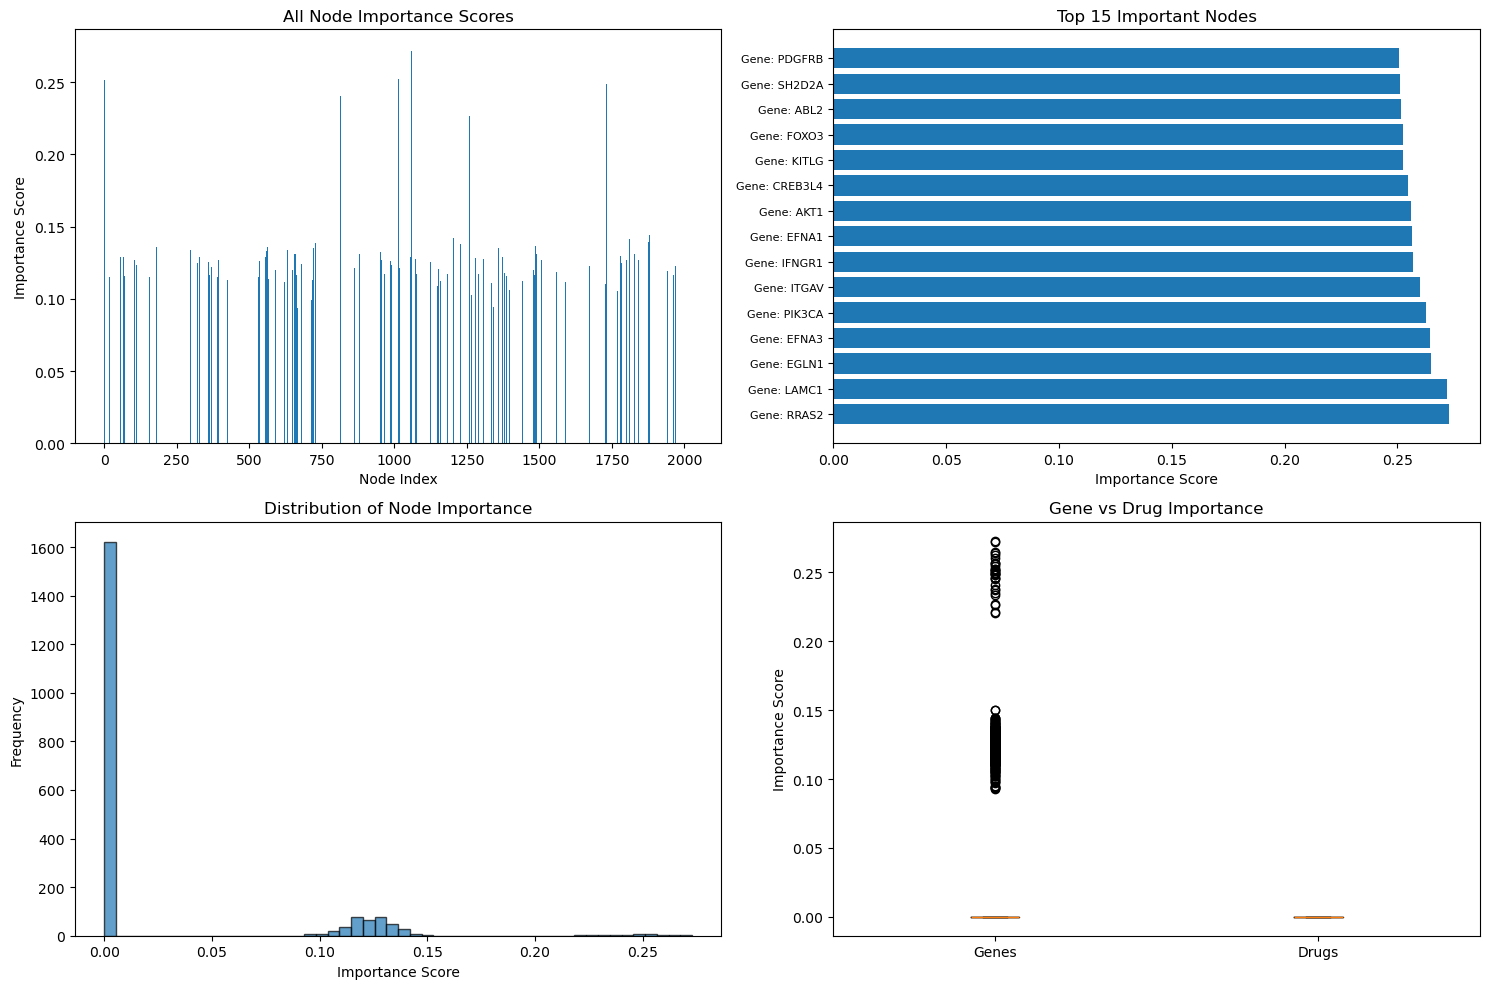


Node Importance Summary:
Total nodes: 2027
Mean importance: 0.0265
Std importance: 0.0554
Max importance: 0.2730
Min importance: 0.0000

Top 15 Important Features:
1. Gene RRAS2: 0.2730
2. Gene LAMC1: 0.2718
3. Gene EGLN1: 0.2649
4. Gene EFNA3: 0.2642
5. Gene PIK3CA: 0.2626
6. Gene ITGAV: 0.2600
7. Gene IFNGR1: 0.2570
8. Gene EFNA1: 0.2565
9. Gene AKT1: 0.2561
10. Gene CREB3L4: 0.2548
11. Gene KITLG: 0.2525
12. Gene FOXO3: 0.2525
13. Gene ABL2: 0.2516
14. Gene SH2D2A: 0.2510
15. Gene PDGFRB: 0.2506


In [36]:
visualize_node_importance(explanation, data, dataset_info, sample_idx, top_k=15)

These plots represent the following:
1. All node importance scores: shows importance scores for all 2027 nodes (2016 genes + 11 drugs) in the graph.Most nodes have low importance (~0.0-0.1), with only a few important features.
2. Top 15 important nodes: RAF1 is the most important gene (highest bar ~0.4 importance) and FGFRL1 is second most important (~0.35 importance). Those are all genes.
3. Distribution of node importance: ~1300 nodes have near-zero importance.
4. Gene vs Drug importance: Genes box plot shows wide range of importance (0.0 to ~0.4), with many outliers. Drugs have minimal impact which makes sence. 

### Edge importance visualization

In [37]:
def visualize_edge_importance(explanation, sample_idx=0):
    """
    Create visualizations showing which edges (connections) are most important for the prediction.
    
    This function creates 2 subplots:
    1. Histogram showing distribution of edge importance scores  
    2. Bar chart of the top 20 most important edges
    
    Args:
        explanation: Explanation object from generate_explanation()
        sample_idx: Sample index for file naming
    """
    if explanation is None or not hasattr(explanation, 'edge_mask') or explanation.edge_mask is None:
        print("No edge importance data to visualize")
        return
    
    edge_importance = explanation.edge_mask.cpu().numpy()
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(edge_importance, bins=50, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Edge Importance Scores')
    plt.xlabel('Importance Score')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    top_edges = np.argsort(edge_importance)[-20:][::-1]  # Top 20 edges
    plt.bar(range(len(top_edges)), edge_importance[top_edges])
    plt.title('Top 20 Important Edges')
    plt.xlabel('Edge Rank')
    plt.ylabel('Importance Score')
    
    plt.tight_layout()
    plt.savefig(f'./explanations/edge_importance_sample_{sample_idx}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nEdge Importance Summary:")
    print(f"Total edges: {len(edge_importance)}")
    print(f"Mean importance: {edge_importance.mean():.4f}")
    print(f"Std importance: {edge_importance.std():.4f}")
    print(f"Max importance: {edge_importance.max():.4f}")
    print(f"Min importance: {edge_importance.min():.4f}")

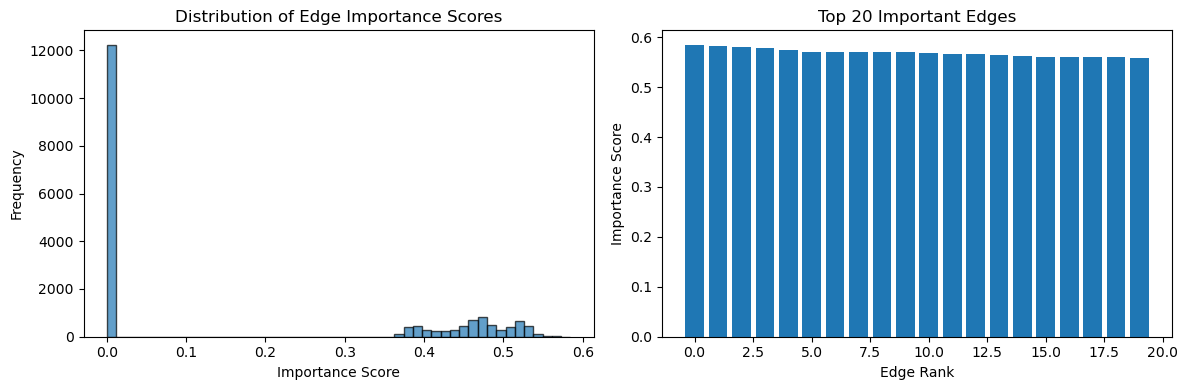


Edge Importance Summary:
Total edges: 18604
Mean importance: 0.1586
Std importance: 0.2215
Max importance: 0.5845
Min importance: 0.0000


In [38]:
visualize_edge_importance(explanation, sample_idx)

1. Distribution of Edge Importance Scores shows importance scores for all 18,604 edges in the network. Edges are either very unimportant or very important - few in between.
2. Top 20 Important Edges have nearly identical importance scores (~0.6). Multiple pathways are equally important for the prediction.

### Prediction accuracy analysis

In [39]:
def show_prediction_info(model, data, sample_idx=0):
    """
    Display prediction accuracy information for the explained sample.
    
    This function shows:
    - True synergy score from the dataset
    - Model's predicted synergy score
    - Prediction error (absolute difference)
    
    Args:
        model: Trained model
        data: Sample data
        sample_idx: Sample index for display
    """
    print(f"\nSample {sample_idx} Prediction Information:")
    
    # Get true value
    if hasattr(data, 'label'):
        true_val = data.label.item()
    else:
        true_val = data.y.item()
    
    print(f"True synergy score: {true_val:.4f}")
    
    # Get model prediction
    with torch.no_grad():
        pred = model(data.x, data.edge_index, data.drug_index)
        print(f"Predicted synergy score: {pred.item():.4f}")
        print(f"Prediction error: {abs(pred.item() - true_val):.4f}")
        
        # Interpretation of synergy scores
        if true_val > 0:
            print("True label: SYNERGISTIC drug combination")
        else:
            print("True label: NON-SYNERGISTIC drug combination")
            
        if pred.item() > 0:
            print("Prediction: SYNERGISTIC drug combination")
        else:
            print("Prediction: NON-SYNERGISTIC drug combination")

In [40]:
show_prediction_info(model, data, sample_idx)


Sample 57 Prediction Information:
True synergy score: 4.6742
tensor(-81.4745)
tensor(-176.1546)
tensor(22.2613)
tensor(-189.4708)
tensor(-17.8991)
tensor(-112.7340)
Parameter containing:
tensor([[-0.0715,  0.2005, -1.2559,  ...,  1.5823,  0.7754, -0.0147],
        [-1.9628, -1.9703, -1.1113,  ..., -1.9637, -0.8874, -1.0504],
        [ 2.4001,  0.8289,  1.6887,  ..., -0.2713,  0.7500, -0.4488],
        ...,
        [ 1.8332,  0.1514, -0.0907,  ..., -0.9216,  0.5136,  0.2529],
        [ 1.9344, -0.2237, -0.0953,  ...,  0.8447, -0.0669,  0.2213],
        [-1.4979, -1.1826,  0.6255,  ..., -0.7059, -0.3628, -0.7292]],
       requires_grad=True)
tensor(-141.8986)
Predicted synergy score: -1.4075
Prediction error: 6.0818
True label: SYNERGISTIC drug combination
Prediction: NON-SYNERGISTIC drug combination


As a result, we can suggest that the model heavily weighted RAF1 expression and FGFRL1. But this has led to a wrong prediction.

## Network Subgraph

In [41]:
def visualize_important_subgraph(explanation, data, dataset_info, sample_idx=0, top_k_nodes=15, top_k_edges=30):
    """
    Visualize the most important subgraph for the prediction, ensuring drug nodes are always included
    """
    import networkx as nx
    
    if explanation is None:
        return
    
    # Get importance scores
    node_importance = explanation.node_mask.mean(dim=1).cpu().numpy() if len(explanation.node_mask.shape) == 2 else explanation.node_mask.cpu().numpy()
    edge_importance = explanation.edge_mask.cpu().numpy()
    edge_index = data.edge_index.cpu().numpy()
    
    print(f"Node importance range: {node_importance.min():.4f} to {node_importance.max():.4f}")
    print(f"Edge importance range: {edge_importance.min():.4f} to {edge_importance.max():.4f}")
    
    # Get drug indices for reference
    drug_indices = [int(idx) for idx in data.drug_index]
    print(f"Drug indices: {drug_indices}")
    
    # Strategy: Get top important edges first, then include their nodes
    top_edge_indices = np.argsort(edge_importance)[-top_k_edges:]
    
    # Create networkx graph
    G = nx.Graph()
    
    # Add all nodes from top edges
    nodes_in_graph = set()
    for edge_idx in top_edge_indices:
        src, dst = edge_index[0, edge_idx], edge_index[1, edge_idx]
        nodes_in_graph.add(src)
        nodes_in_graph.add(dst)
        G.add_edge(src, dst, importance=edge_importance[edge_idx], edge_idx=edge_idx)
    
    # ALWAYS add the drug nodes from the sample
    for drug_idx in drug_indices:
        nodes_in_graph.add(drug_idx)
        if not G.has_node(drug_idx):
            G.add_node(drug_idx)
    
    # Also add top important nodes if they're not already included
    top_nodes = np.argsort(node_importance)[-top_k_nodes:]
    for node in top_nodes:
        nodes_in_graph.add(node)
        if not G.has_node(node):
            G.add_node(node)
    
    # Add edges connected to drug nodes (to show drug-gene connections)
    for drug_idx in drug_indices:
        # Find all edges connected to this drug
        drug_edges = np.where((edge_index[0] == drug_idx) | (edge_index[1] == drug_idx))[0]
        # Add the most important edges connected to this drug
        if len(drug_edges) > 0:
            drug_edge_importance = edge_importance[drug_edges]
            # Sort and take top 5 connections for each drug
            top_drug_edges = drug_edges[np.argsort(drug_edge_importance)[-5:]]
            
            for edge_idx in top_drug_edges:
                src, dst = edge_index[0, edge_idx], edge_index[1, edge_idx]
                nodes_in_graph.add(src)
                nodes_in_graph.add(dst)
                G.add_edge(src, dst, importance=edge_importance[edge_idx], edge_idx=edge_idx)
    
    # Add node attributes
    for node in nodes_in_graph:
        if node < len(dataset_info['gene_names']):
            node_name = dataset_info['gene_names'][node]
            node_type = 'gene'
        else:
            drug_name_idx = node - dataset_info['num_gene']
            if drug_name_idx < len(dataset_info['drug_names']):
                node_name = dataset_info['drug_names'][drug_name_idx]
                node_type = 'drug'
            else:
                node_name = f"Node_{node}"
                node_type = 'unknown'
        
        G.add_node(node, 
                  name=node_name, 
                  type=node_type,
                  importance=node_importance[node] if node < len(node_importance) else 0,
                  is_drug=node in drug_indices)
    
    print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")
    
    if G.number_of_edges() == 0:
        print("No edges found in graph!")
        return
    
    # Create visualization
    plt.figure(figsize=(16, 12))
    
    # Use spring layout with more iterations for better separation
    pos = nx.spring_layout(G, k=3, iterations=200, seed=42)
    
    # Separate drug and gene nodes
    drug_nodes = [node for node in G.nodes() if G.nodes[node]['is_drug']]
    gene_nodes = [node for node in G.nodes() if not G.nodes[node]['is_drug']]
    
    print(f"Drug nodes found: {drug_nodes}")
    print(f"Gene nodes count: {len(gene_nodes)}")
    
    # Draw gene nodes
    if gene_nodes:
        gene_colors = [G.nodes[node]['importance'] for node in gene_nodes]
        gene_sizes = [max(200, G.nodes[node]['importance'] * 2000) for node in gene_nodes]
        
        nodes_genes = nx.draw_networkx_nodes(G, pos, 
                                           nodelist=gene_nodes,
                                           node_color=gene_colors, 
                                           node_size=gene_sizes,
                                           cmap=plt.cm.Reds, 
                                           alpha=0.8,
                                           node_shape='o')
    
    # Draw drug nodes (larger, different color)
    if drug_nodes:
        nodes_drugs = nx.draw_networkx_nodes(G, pos,
                                           nodelist=drug_nodes,
                                           node_color='gold',
                                           node_size=1500,
                                           alpha=0.9,
                                           node_shape='D',
                                           edgecolors='black',
                                           linewidths=3)
        print(f"Drew {len(drug_nodes)} drug nodes")
    else:
        print("No drug nodes to draw!")
    
    # Draw edges with varying thickness
    edge_colors = [G[u][v]['importance'] for u, v in G.edges()]
    edge_widths = [max(1, G[u][v]['importance'] * 10) for u, v in G.edges()]
    
    edges = nx.draw_networkx_edges(G, pos, 
                                 edge_color=edge_colors, 
                                 width=edge_widths,
                                 edge_cmap=plt.cm.Blues, 
                                 alpha=0.7)
    
    # Add labels
    labels = {}
    for node in G.nodes():
        name = G.nodes[node]['name']
        if G.nodes[node]['is_drug']:
            labels[node] = name[:10]  # Show full drug name (they're short)
        else:
            labels[node] = name[:8]   # Truncate gene names
    
    nx.draw_networkx_labels(G, pos, labels, font_size=10, font_weight='bold')
    
    plt.title(f'Important Subgraph for Sample {sample_idx}\n'
              f'Drugs: {[G.nodes[n]["name"] for n in drug_nodes]}\n'
              f'Top {top_k_edges} edges and {top_k_nodes} nodes + drug connections\n'
              f'({G.number_of_nodes()} nodes, {G.number_of_edges()} edges)')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='red', alpha=0.8, label='Genes (size/color = importance)'),
        Patch(facecolor='gold', alpha=0.9, label='Drugs'),
        plt.Line2D([0], [0], color='blue', alpha=0.7, label='Edges (width = importance)')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Add colorbar if we have gene nodes
    if gene_nodes and 'nodes_genes' in locals():
        cbar = plt.colorbar(nodes_genes, ax=plt.gca(), shrink=0.8, pad=0.1)
        cbar.set_label('Gene Importance', rotation=270, labelpad=15)
    
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'./explanations/important_subgraph_with_drugs_sample_{sample_idx}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed analysis
    print(f"\nDetailed Analysis:")
    print(f"Drug nodes in graph: {[G.nodes[node]['name'] for node in drug_nodes]}")
    
    # Show top connected genes to drugs
    for drug_node in drug_nodes:
        neighbors = list(G.neighbors(drug_node))
        if neighbors:
            neighbor_info = [(n, G.nodes[n]['name'], G.nodes[n]['importance']) for n in neighbors]
            neighbor_info.sort(key=lambda x: x[2], reverse=True)
            drug_name = G.nodes[drug_node]['name']
            print(f"\n{drug_name} is connected to {len(neighbors)} genes:")
            for node_id, name, imp in neighbor_info[:5]:  # Show top 5
                print(f"  - {name}: importance {imp:.4f}")
        else:
            print(f"\n{G.nodes[drug_node]['name']} has no connections in this subgraph")
    
    return G

Node importance range: 0.0000 to 0.2730
Edge importance range: 0.0000 to 0.5845
Drug indices: [2021, 2024]
Graph created with 60 nodes and 34 edges
Drug nodes found: [2021, 2024]
Gene nodes count: 58
Drew 2 drug nodes


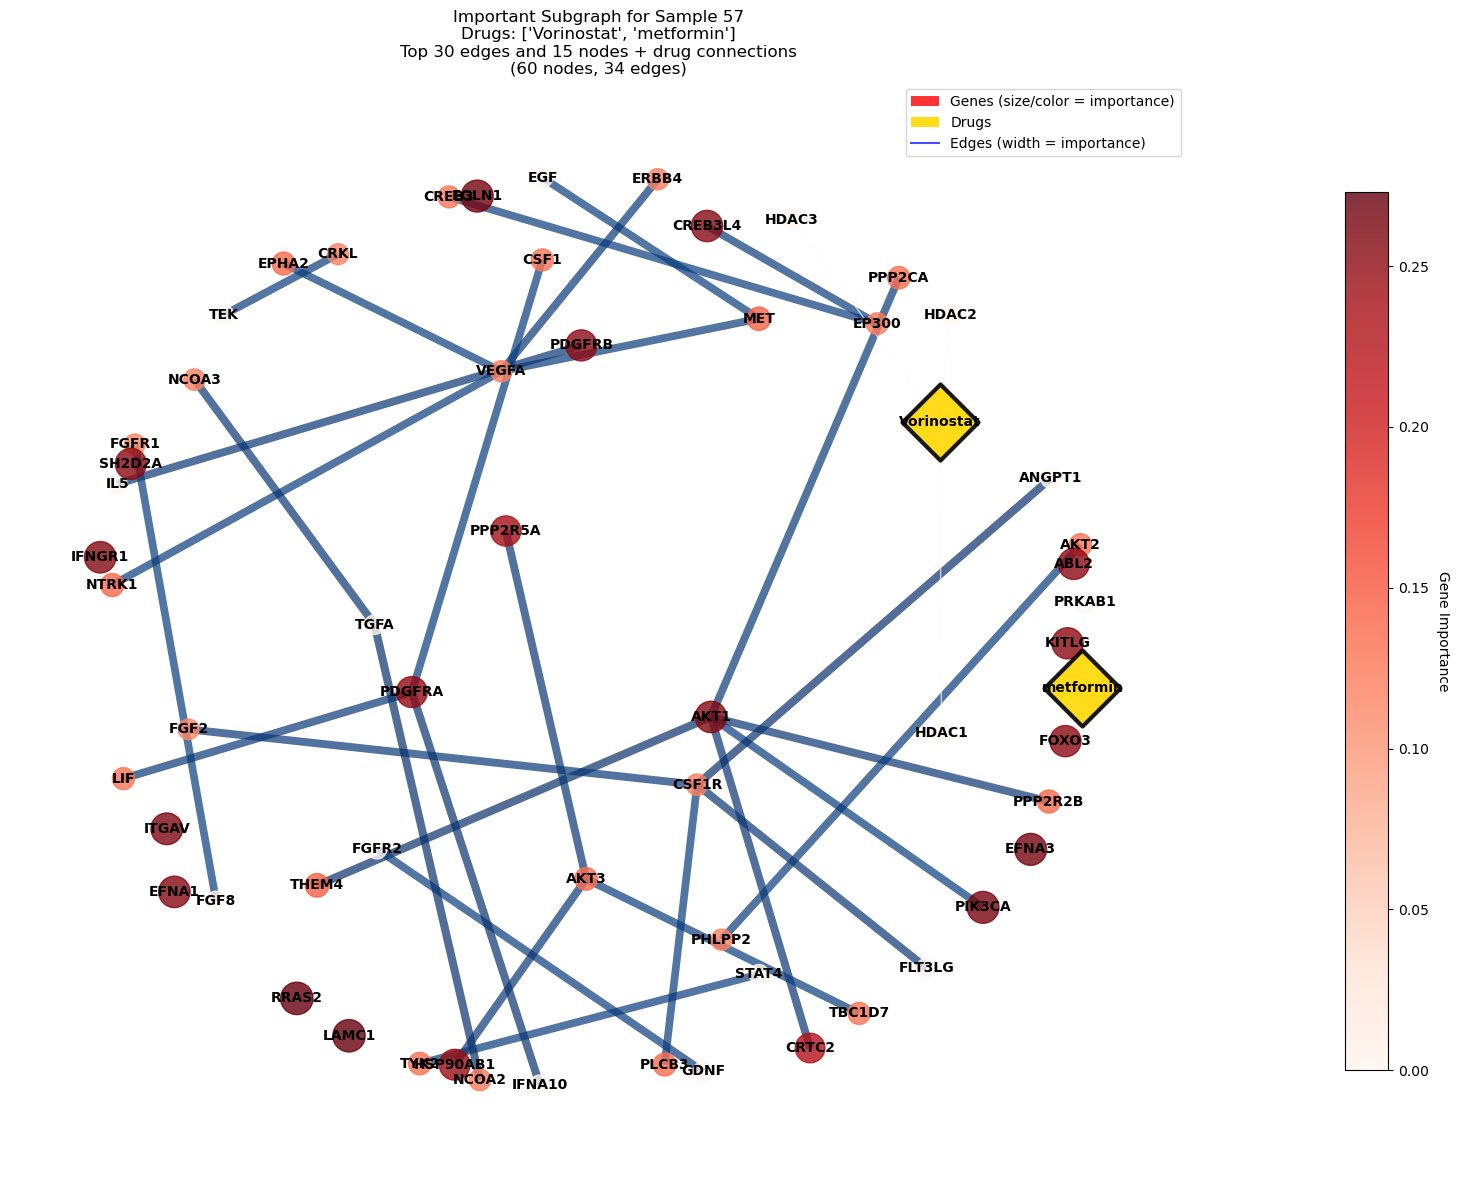


Detailed Analysis:
Drug nodes in graph: ['Vorinostat', 'metformin']

Vorinostat is connected to 3 genes:
  - HDAC2: importance 0.0000
  - HDAC3: importance 0.0000
  - HDAC1: importance 0.0000

metformin is connected to 1 genes:
  - PRKAB1: importance 0.0000


In [42]:
visualize_important_subgraph(explanation, data, dataset_info, sample_idx, 15, 30)